In [1]:
from library.scoreCalculatorLibrary import calculate_score

In [2]:
import os
import pandas as pd
import pickle

In [3]:
# converts hour:minute:seconds to seconds
def time_as_int(timestr):
    hh, mm, ss = timestr.split(":")
    time_int = (int(hh)*3600)+(int(mm)*60)+int(ss)
    return time_int

In [4]:
# name = "prantika_bus_stand"
# name = "junction_mall"
name = "54ft_road"
# name = "dvc_more"
# name = "station"

In [5]:
parent_dir = r"../data/54ft/"
results_csv_name = f"Predictions_merged_54ft_{name}_zone.csv"
reports_dir = f"../reports/54ft/{name}"
plots_dir_name = r"score_plots&correlations"
instance_score_dir = r"instance_wise_scores"
scores_pickle = f"scores_pickle_{name}"

column = 'instance_date'

In [6]:
os.makedirs(reports_dir, exist_ok=True)
os.makedirs(os.path.join(reports_dir, plots_dir_name), exist_ok=True)
os.makedirs(os.path.join(reports_dir, instance_score_dir), exist_ok=True)

In [7]:
result_df = pd.read_csv(os.path.join(parent_dir, results_csv_name))
date_group = result_df.groupby(column)

In [8]:
keys = list(date_group.groups.keys())
all_scores = {}
instance_scores = {}
instances_count = {}
for key in keys:
    df = date_group.get_group(key).copy()
    df["instance_start_time"] = df["instance_start_time"].apply(lambda x: time_as_int(x))
    df["instance_end_time"] = df["instance_end_time"].apply(lambda x: time_as_int(x))
    overall_score, list_scores, no_of_instances = calculate_score(df)
    all_scores[key] = overall_score
    instance_scores[key] = list_scores
    instances_count[key] = no_of_instances

In [9]:
all_scores

{'09/14/2019': 0.0,
 '09/15/2019': -1.0,
 '09/16/2019': 0.7745966692414834,
 '09/17/2019': 0.8864511697746048,
 '09/20/2019': 0.0,
 '09/21/2019': 1.5,
 '09/23/2019': 0.6546536707079772}

In [10]:
instances_count

{'09/14/2019': 8,
 '09/15/2019': 9,
 '09/16/2019': 15,
 '09/17/2019': 17,
 '09/20/2019': 12,
 '09/21/2019': 16,
 '09/23/2019': 21}

## creating instance wise score df

In [11]:
def generate_time_list(df, time_column):
    times = []
    
    for index, row in df.iterrows():
        condition = row["Prediction Is_Adhoc"] == "Adhoc" or row["Prediction Is_Bus_stop"] == "Bus_stop" \
        or row["Prediction Is_Signal"] == "Signal" or row["Prediction Is_Congestion"] == "Congestion"
        if condition:
            times.append(row[time_column])
        else:
            pass
    
    return times

In [12]:
def generate_instance_score_df(start_times, end_times, scores):
    df = pd.DataFrame(columns=['start_time', 'end_time', 'score'])
    df['start_time'] = start_times
    df['end_time'] = end_times
    df['score'] = scores
    return df

In [13]:
def format_date(mmddyyyy):
    mmddyyyy = mmddyyyy.split("/")
    ddmmyyyy = f"{mmddyyyy[1]}_{mmddyyyy[0]}_{mmddyyyy[2]}"
    return ddmmyyyy

In [14]:
instance_score_dfs = {}
instance_start_times = {}
instance_end_times = {}
for key in keys:
    df = date_group.get_group(key).copy()
    start_times = generate_time_list(df, 'instance_start_time')
    end_times = generate_time_list(df, 'instance_end_time')
    instance_start_times[key] = start_times
    instance_end_times[key] = end_times
    instance_score_dfs[key] = generate_instance_score_df(start_times, end_times, instance_scores[key])

In [15]:
for key in instance_score_dfs:
    csv_name = format_date(key)
    path = os.path.join(reports_dir, instance_score_dir, f"{csv_name}.csv")
    df = instance_score_dfs[key]
    print(f"{key}: {len(df)}")
    df.to_csv(path, index=False)

09/14/2019: 8
09/15/2019: 9
09/16/2019: 15
09/17/2019: 17
09/20/2019: 12
09/21/2019: 16
09/23/2019: 21


## Plots

In [16]:
import matplotlib.pyplot as plt

### Boxplot

In [17]:
data = [instance_scores.get(key) for key in instance_scores.keys()]

#### Saving Scores Pickle

In [18]:
with open(os.path.join(reports_dir, scores_pickle), "wb") as outfile:
    pickle.dump(data, outfile)

#### Plotting

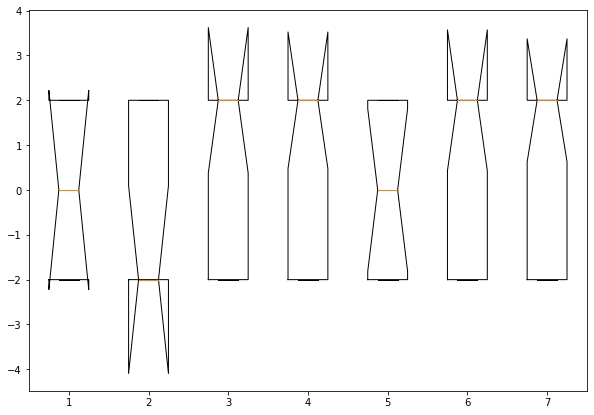

In [19]:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot()
ax.boxplot(data, notch=True)
fig.savefig(os.path.join(reports_dir, plots_dir_name, "boxplot.png"))
plt.show()

###  View plots

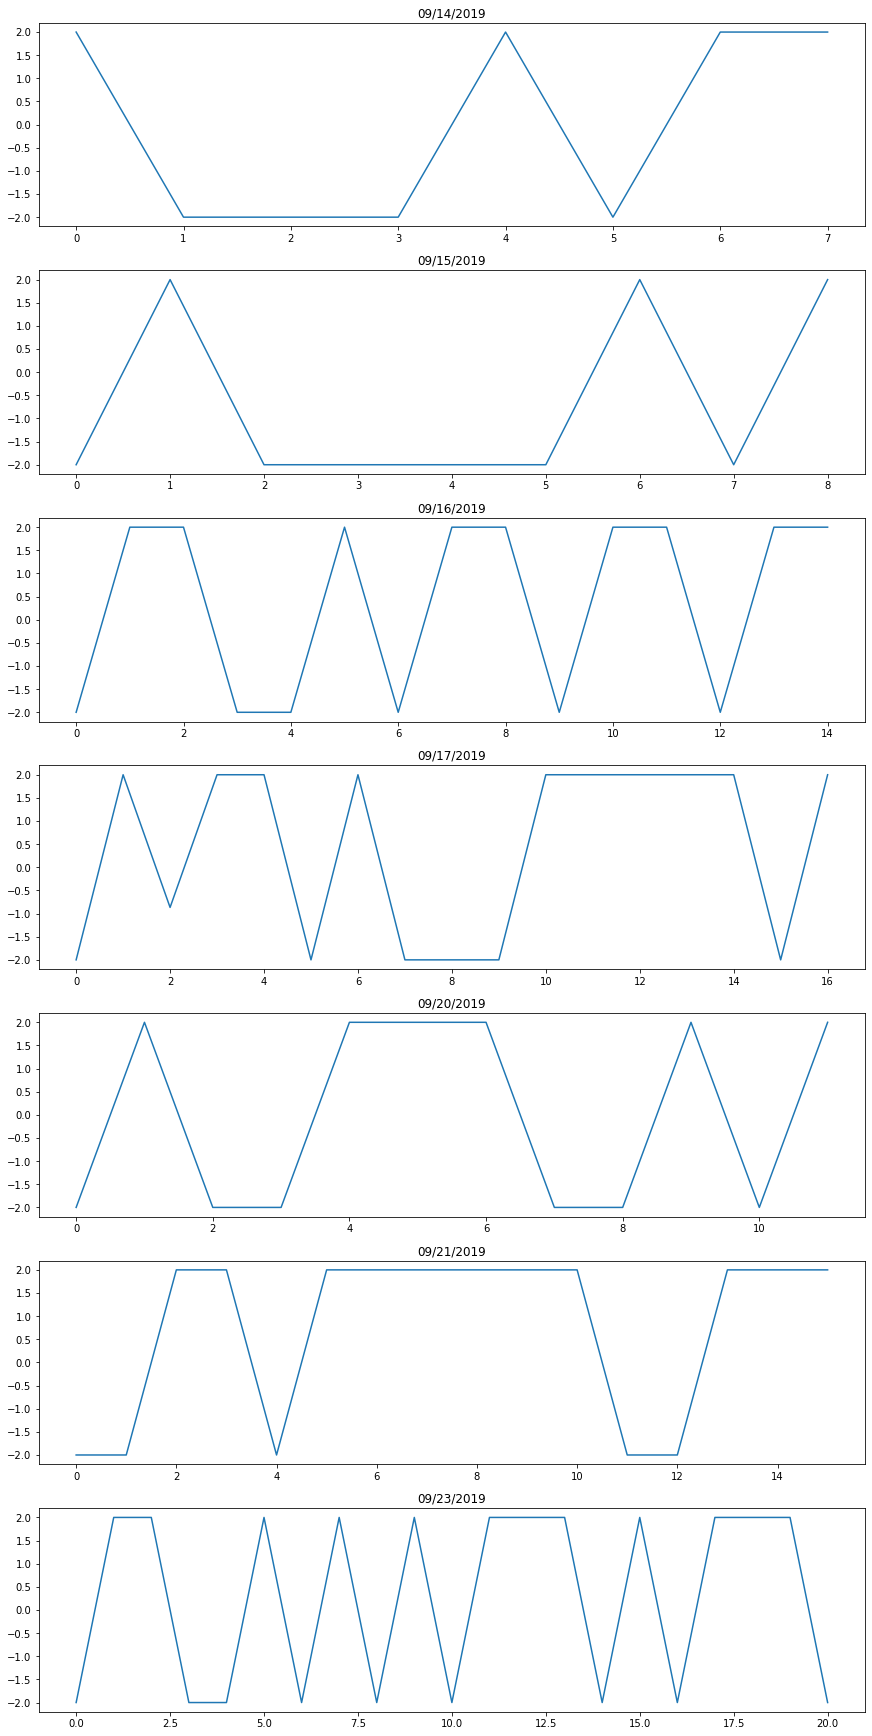

In [20]:
fig, axes = plt.subplots(len(instance_scores), 1, squeeze=False, figsize=(12, 24), constrained_layout=True)
keys = list(instance_scores.keys())
key_index = 0
for key, ax in zip(instance_scores, axes.flat):
    ax.plot(instance_scores.get(key))
    ax.set_title(key)

### Save Plots

In [21]:
for key in instance_scores:
    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot()
    ax.plot(instance_scores.get(key))
    ax.set_title(key)
    outname = "-".join(key.split("/"))
    fig.savefig(os.path.join(reports_dir, plots_dir_name, f"{outname}.png"))
    plt.close(fig)

## Correlation

In [22]:
from library.correlationAndTtestLib import *

In [23]:
pairs_with_scores = form_pairs_with_scores(instance_scores)
print("Total pairs formed: %d" %len(pairs_with_scores))

Total pairs formed: 21


### Kendalltau

In [24]:
kendalltau_correlations, pair_instance_count = kendalltau_corr(pairs_with_scores)
kendalltau_correlations

{('09/14/2019', '09/15/2019'): (0.0, 1.0),
 ('09/14/2019', '09/16/2019'): (-0.5, 0.18587673236587587),
 ('09/14/2019', '09/17/2019'): (-0.11470786693528087, 0.7518296340458492),
 ('09/14/2019', '09/20/2019'): (0.0, 1.0),
 ('09/14/2019', '09/21/2019'): (-0.2581988897471611, 0.4945246678838707),
 ('09/14/2019', '09/23/2019'): (-0.5, 0.18587673236587587),
 ('09/15/2019', '09/16/2019'): (0.15811388300841897, 0.6547208460185772),
 ('09/15/2019', '09/17/2019'): (0.2405626121623441, 0.4795001221869535),
 ('09/15/2019', '09/20/2019'): (0.31622776601683794, 0.37109336952269756),
 ('09/15/2019', '09/21/2019'): (0.0, 1.0),
 ('09/15/2019', '09/23/2019'): (-0.15811388300841897, 0.6547208460185772),
 ('09/16/2019', '09/17/2019'): (-0.07086586712703119, 0.7854947471183542),
 ('09/16/2019', '09/20/2019'): (-0.16903085094570333, 0.5750621301739498),
 ('09/16/2019', '09/21/2019'): (0.28867513459481287, 0.28008721081149757),
 ('09/16/2019', '09/23/2019'): (0.32732683535398854, 0.22067136191984682),
 ('09

In [25]:
pair_instance_count

{('09/14/2019', '09/15/2019'): 8,
 ('09/14/2019', '09/16/2019'): 8,
 ('09/14/2019', '09/17/2019'): 8,
 ('09/14/2019', '09/20/2019'): 8,
 ('09/14/2019', '09/21/2019'): 8,
 ('09/14/2019', '09/23/2019'): 8,
 ('09/15/2019', '09/16/2019'): 9,
 ('09/15/2019', '09/17/2019'): 9,
 ('09/15/2019', '09/20/2019'): 9,
 ('09/15/2019', '09/21/2019'): 9,
 ('09/15/2019', '09/23/2019'): 9,
 ('09/16/2019', '09/17/2019'): 15,
 ('09/16/2019', '09/20/2019'): 12,
 ('09/16/2019', '09/21/2019'): 15,
 ('09/16/2019', '09/23/2019'): 15,
 ('09/17/2019', '09/20/2019'): 12,
 ('09/17/2019', '09/21/2019'): 16,
 ('09/17/2019', '09/23/2019'): 17,
 ('09/20/2019', '09/21/2019'): 12,
 ('09/20/2019', '09/23/2019'): 12,
 ('09/21/2019', '09/23/2019'): 16}

### Welch's T-Test

In [26]:
welch = welch_t(pairs_with_scores)
welch

{('09/14/2019', '09/15/2019'): (0.6614378277661476, 0.5187286762047036),
 ('09/14/2019', '09/16/2019'): (-0.4349588362008401, 0.6703419349268521),
 ('09/14/2019', '09/17/2019'): (-0.46956773947318786, 0.6465716367840574),
 ('09/14/2019', '09/20/2019'): (0.0, 1.0),
 ('09/14/2019', '09/21/2019'): (-0.83821371408685, 0.41731118495569186),
 ('09/14/2019', '09/23/2019'): (-0.3261640365267211, 0.7498613936832415),
 ('09/15/2019', '09/16/2019'): (-1.2581887256123185, 0.22515352373788985),
 ('09/15/2019', '09/17/2019'): (-1.3255996967017838, 0.20341471440496237),
 ('09/15/2019', '09/20/2019'): (-0.7416198487095663, 0.4679977821692086),
 ('09/15/2019', '09/21/2019'): (-1.7260884807271524, 0.10347383163084745),
 ('09/15/2019', '09/23/2019'): (-1.1901388973144478, 0.25200476685955553),
 ('09/16/2019', '09/17/2019'): (-0.027675077509365494, 0.9781093282139716),
 ('09/16/2019', '09/20/2019'): (0.5008136701883816, 0.6211816273942958),
 ('09/16/2019', '09/21/2019'): (-0.493274704186718, 0.62559032360